# Import Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

from statsmodels.tsa.api import VAR

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN

# Preprocess 1

In [15]:
# Load CO2 and Temperature data
co2_df = pd.read_csv("./processed_data/co2_emissions.csv")
temp_df = pd.read_csv("./processed_data/Temperature_of_countries.csv")

# Select data from 1995 to 2021
co2_df = co2_df.loc[co2_df['Year'] >= 1995, :]
temp_df = temp_df.loc[temp_df['Year'] >= 1995, :]

# Merge the data
merged_df = pd.merge(co2_df, temp_df, on=['ISO', 'Year'])

# Drop unwanted colums
merged_df.drop(columns=['Country_y'], inplace=True)

In [16]:
# Load methane dataset
methane_df = pd.read_csv("./processed_data/methane_emissions.csv")
methane_df

# Select data from 1995 to 2021
methane_df = methane_df.loc[methane_df['Year'] >= 1995, :]

# merge to merge_df
merged_df = pd.merge(merged_df, methane_df, on=['ISO', 'Year'])

# drop unwanted columns
merged_df.drop(columns=['Country'], inplace=True)

In [17]:
# Load NO2 dataset
ni_df = pd.read_csv("./processed_data/nitrous_oxide_emission.csv")

# Select year from 1995 to 2021
ni_df = ni_df.loc[ni_df['Year'] >= 1995, :]

# Merge to merged_df
merged_df = pd.merge(merged_df, ni_df, on=['ISO', 'Year'])
merged_df.drop(columns=['Country'], inplace=True)


In [18]:
# Load population dataset
population_df = pd.read_csv("./processed_data/population.csv")

# Select from 1995 to 2021
population_df = population_df.loc[population_df['Year'] >= 1995, :]

# Merge dataset
merged_df = pd.merge(merged_df, population_df, on=['ISO', 'Year'])
merged_df.drop(columns=['Country'], inplace=True)

In [19]:
# Load gdp data
gdp_df = pd.read_csv("./raw_data/change-energy-gdp-per-capita.csv")

# select year from 1995
gdp_df = gdp_df.loc[gdp_df['Year'] >= 1995, :]

gdp_df.drop(columns=['consumption_per_capita', 'production_per_capita'], inplace=True)

gdp_df = gdp_df.rename(
    columns={
        'Entity': 'Country',
        'Code': 'ISO'
    }
)

merged_df = pd.merge(merged_df, gdp_df, on=['ISO', 'Year'], how='left')
merged_df.drop(columns=['Country'], inplace=True)

merged_df = merged_df.rename(
    columns={
        'Country_x': 'Country',
    }
)



In [20]:
new_column_order = ['Country', 'ISO', 'Year', 'Annual CO2 emissions (per capita)',
       'Per-capita methane emissions in CO2 equivalents',
       'Per-capita nitrous oxide emissions in CO2 equivalents',
       'Population - Sex: all - Age: all - Variant: estimates',
       'GDP per capita, PPP (constant 2017 international $)', 'Temperature']

In [21]:
merged_df = merged_df.reindex(columns=new_column_order)

In [22]:
import os

if not os.path.exists("dataset"):
    os.makedirs("dataset")

merged_df.to_csv('dataset/data1.csv', index=False)

# Exploratory Data Analysis

In [23]:
# Load data
dataset = pd.read_csv("dataset/data.csv")
dataset.head()

,Country,ISO,Year,Annual CO2 emissions (per capita),Per-capita methane emissions in CO2 equivalents,Per-capita nitrous oxide emissions in CO2 equivalents,Population - Sex: all - Age: all - Variant: estimates,"GDP per capita, PPP (constant 2017 international $)",Temperature
0,Afghanistan,AFG,1995,0.086323,0.582011,0.160896,16418911.0,NaN,0.359
1,Afghanistan,AFG,1996,0.080092,0.616903,0.167429,17106600.0,NaN,-0.116
2,Afghanistan,AFG,1997,0.073313,0.639881,0.177091,17788818.0,NaN,0.471
3,Afghanistan,AFG,1998,0.069134,0.650288,0.184699,18493134.0,NaN,0.675
4,Afghanistan,AFG,1999,0.056671,0.672737,0.190177,19262854.0,NaN,1.198


In [28]:
# Rename columns
rename_columns = ["Country", "ISO", "Year", "CO2_Emissions", "MH4_Emissions", "N2O_Emissions", "Population", "GDP", "Temperature"]

dataset.columns = rename_columns

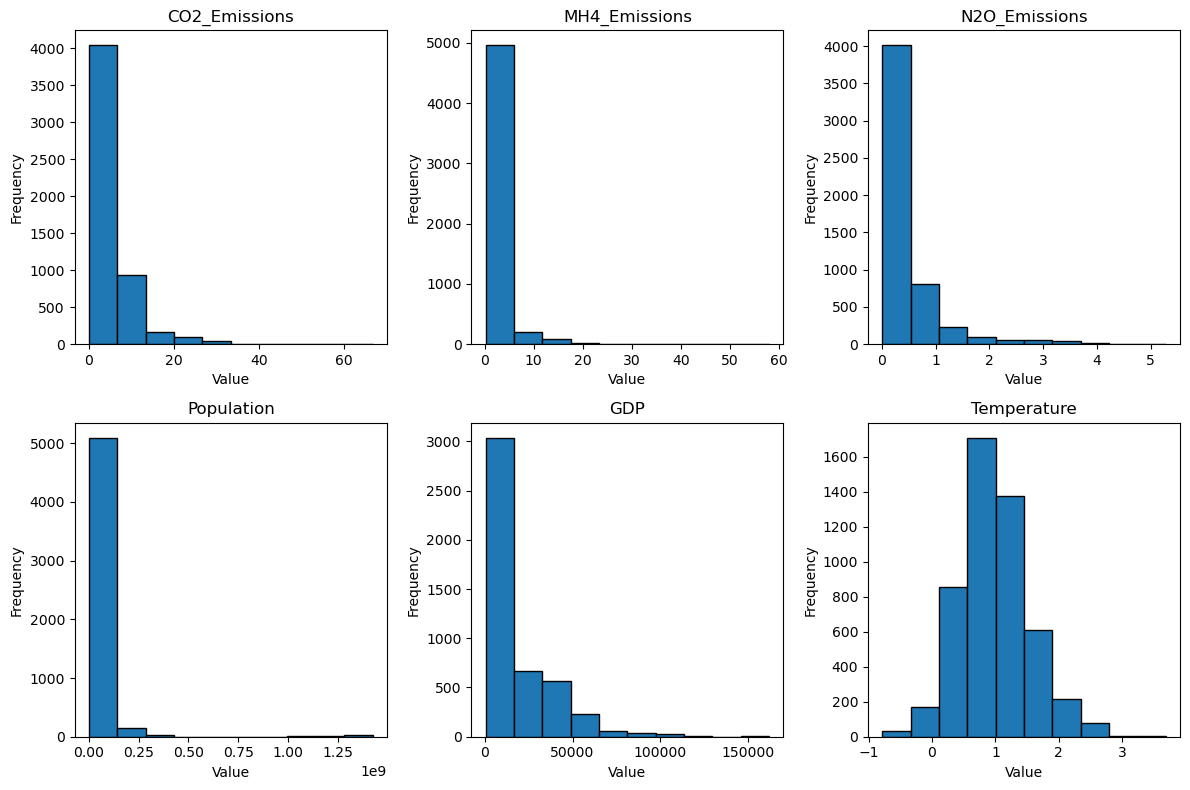

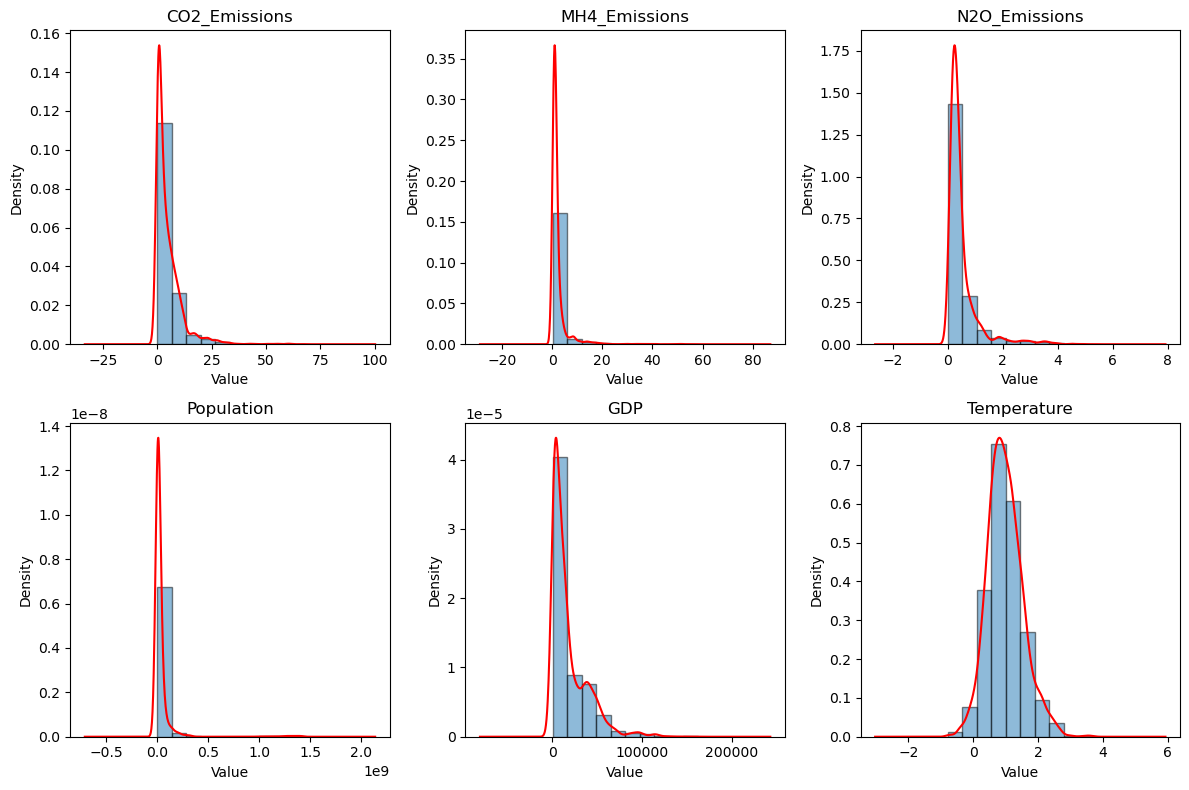

In [29]:
numerical_columns = rename_columns[3:]

# Plotting histograms for numerical variables
plt.figure(figsize=(12, 8))
for i, column in enumerate(numerical_columns):
    plt.subplot(2, 3, i+1)
    plt.hist(dataset[column], edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plotting density plots for numerical variables
plt.figure(figsize=(12, 8))
for i, column in enumerate(numerical_columns):
    plt.subplot(2, 3, i+1)
    plt.hist(dataset[column], density=True, edgecolor='black', alpha=0.5)
    dataset[column].plot(kind='kde', color='red')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

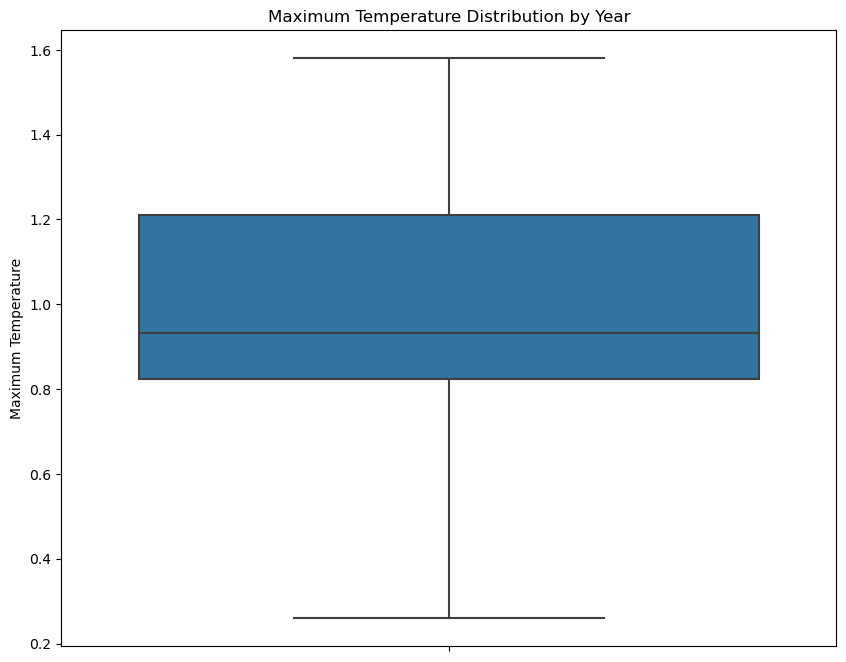

In [30]:
year_temp = dataset.groupby("Year").agg(
    {
        'Temperature': 'mean'
    }
)

# Set the figure size
plt.figure(figsize=(10, 8))

# Create the box plot
sns.boxplot(data=year_temp, y='Temperature')

# Set labels and title
plt.ylabel('Maximum Temperature')
plt.title('Maximum Temperature Distribution by Year')

# Show the plot
plt.show()

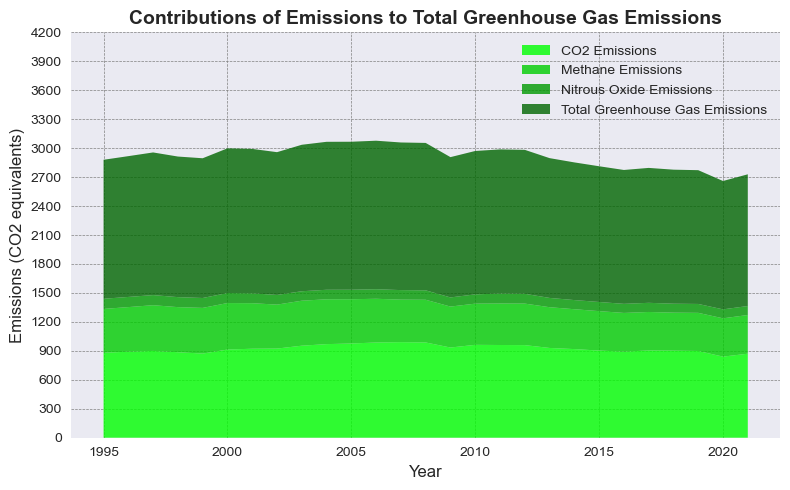

In [31]:
# Group the data by year and calculate the total greenhouse gas emissions
dataset['Total Emissions'] = dataset['CO2_Emissions'] + dataset['MH4_Emissions'] + dataset['N2O_Emissions']
yearly_totals = dataset.groupby('Year')['Total Emissions'].sum()

# Create a new DataFrame for the stacked area plot
stacked_data = pd.DataFrame({
    'CO2 Emissions': dataset.groupby('Year')['CO2_Emissions'].sum(),
    'Methane Emissions': dataset.groupby('Year')['MH4_Emissions'].sum(),
    'Nitrous Oxide Emissions': dataset.groupby('Year')['N2O_Emissions'].sum(),
    'Total Greenhouse Gas Emissions': yearly_totals
})

plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(8, 5))

ax.stackplot(
    stacked_data.index,
    stacked_data['CO2 Emissions'],
    stacked_data['Methane Emissions'],
    stacked_data['Nitrous Oxide Emissions'],
    stacked_data['Total Greenhouse Gas Emissions'],
    labels=['CO2 Emissions', 'Methane Emissions', 'Nitrous Oxide Emissions', 'Total Greenhouse Gas Emissions'],
    colors=['#00ff00', '#00cc00', '#009900', '#006600'],  # Different shades of green
    alpha=0.8
)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Emissions (CO2 equivalents)', fontsize=12)
ax.set_title('Contributions of Emissions to Total Greenhouse Gas Emissions', fontsize=14, fontweight='bold')

ax.tick_params(axis='both', which='both', labelsize=10, length=0)
ax.xaxis.set_tick_params(width=0.5)
ax.yaxis.set_tick_params(width=0.5)

ax.grid(color='gray', linestyle='--', linewidth=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

yticks = np.arange(0, 4500, 300)
ax.set_yticks(yticks)

ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()


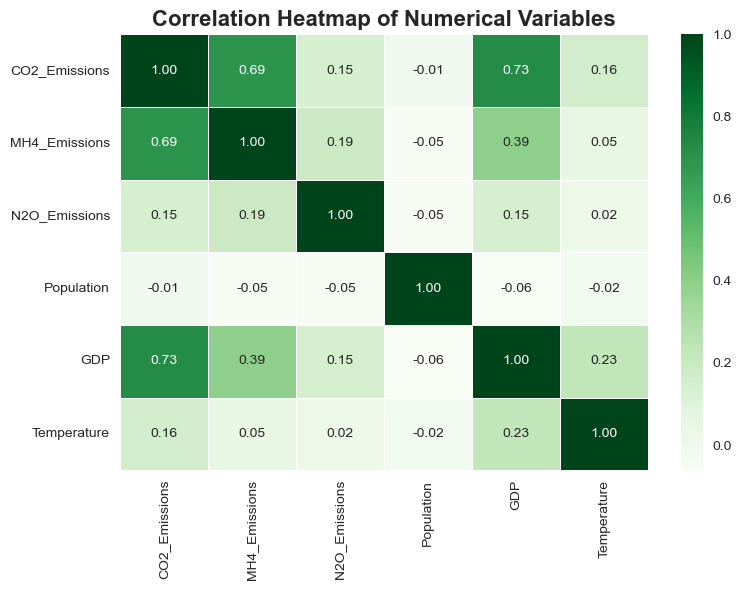

In [32]:

# Select the numerical columns for the heatmap
numerical_cols = rename_columns[3:]

plt.style.use('seaborn')

correlation_matrix = dataset[numerical_cols].corr()

cmap = sns.color_palette("Greens", as_cmap=True)

fig, ax = plt.subplots(figsize=(8, 6))
heatmap = sns.heatmap(data=correlation_matrix, annot=True, cmap=cmap, fmt='.2f', linewidths=0.5, ax=ax)

ax.set_title('Correlation Heatmap of Numerical Variables', fontsize=16, fontweight='bold')

ax.tick_params(axis='both', which='both', labelsize=10, length=0)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

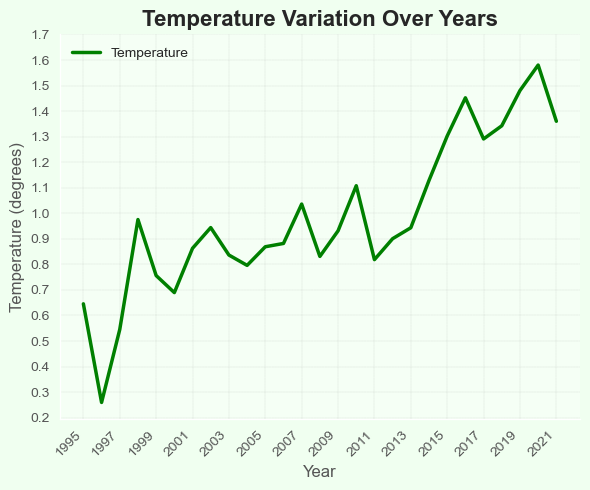

In [33]:
# Set the style
plt.style.use('ggplot')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 5))

year_temp.plot(kind="line", ax=ax, color='green', linewidth=2.5)

ax.set_title("Temperature Variation Over Years", fontsize=16, fontweight='bold')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Temperature (degrees)", fontsize=12)

ax.tick_params(axis='both', which='both', labelsize=10, length=0)
ax.xaxis.set_tick_params(width=0.5)
ax.yaxis.set_tick_params(width=0.5)

ax.grid(color='gray', linestyle='--', linewidth=0.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.patch.set_facecolor('#f0fff0')

ax.set_facecolor('#f5fff5')

xticks = range(1995, 2022, 2)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45, ha='right')

yticks = np.arange(0.2, 1.8, 0.1)
ax.set_yticks(yticks)

ax.legend(["Temperature"], loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


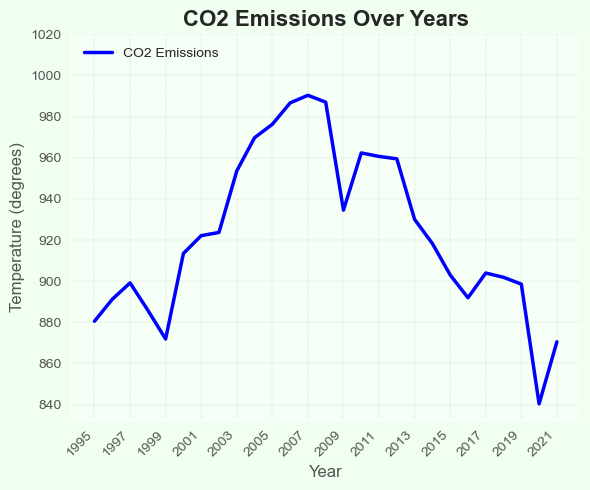

In [34]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(6, 5))

dataset.groupby('Year')['CO2_Emissions'].sum().plot(kind="line", ax=ax, color='blue', linewidth=2.5)

ax.set_title("CO2 Emissions Over Years", fontsize=16, fontweight='bold')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Temperature (degrees)", fontsize=12)


ax.tick_params(axis='both', which='both', labelsize=10, length=0)
ax.xaxis.set_tick_params(width=0.5)
ax.yaxis.set_tick_params(width=0.5)

ax.grid(color='gray', linestyle='--', linewidth=0.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.patch.set_facecolor('#f0fff0')

ax.set_facecolor('#f5fff5')

xticks = range(1995, 2022, 2)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45, ha='right')

yticks = range(840, 1040, 20)
ax.set_yticks(yticks)

ax.legend(["CO2 Emissions"], loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

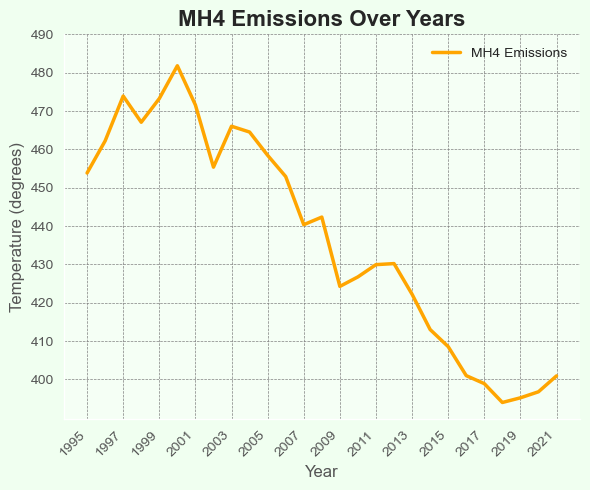

In [35]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(6, 5))

dataset.groupby('Year')['MH4_Emissions'].sum().plot(kind="line", ax=ax, color='orange', linewidth=2.5)

ax.set_title("MH4 Emissions Over Years", fontsize=16, fontweight='bold')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Temperature (degrees)", fontsize=12)

ax.tick_params(axis='both', which='both', labelsize=10, length=0)
ax.xaxis.set_tick_params(width=0.5)
ax.yaxis.set_tick_params(width=0.5)

ax.grid(color='gray', linestyle='--', linewidth=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.patch.set_facecolor('#f0fff0')

ax.set_facecolor('#f5fff5')

xticks = range(1995, 2022, 2)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45, ha='right')

yticks = range(400, 500, 10)
ax.set_yticks(yticks)

ax.legend(["MH4 Emissions"], loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

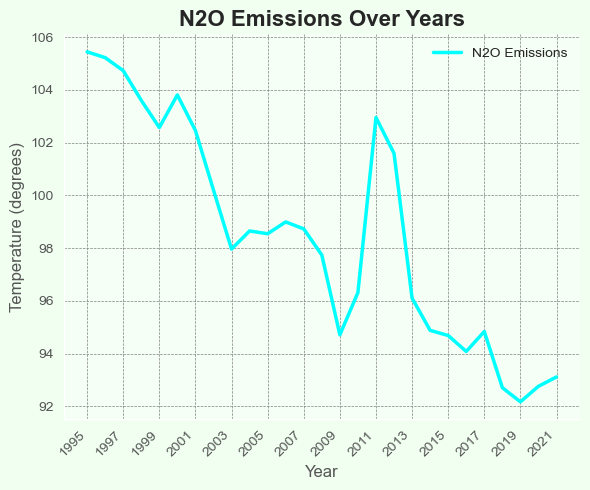

In [36]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(6, 5))

dataset.groupby('Year')['N2O_Emissions'].sum().plot(kind="line", ax=ax, color='cyan', linewidth=2.5)

ax.set_title("N2O Emissions Over Years", fontsize=16, fontweight='bold')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Temperature (degrees)", fontsize=12)


ax.tick_params(axis='both', which='both', labelsize=10, length=0)
ax.xaxis.set_tick_params(width=0.5)
ax.yaxis.set_tick_params(width=0.5)

ax.grid(color='gray', linestyle='--', linewidth=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.patch.set_facecolor('#f0fff0')

ax.set_facecolor('#f5fff5')

xticks = range(1995, 2022, 2)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45, ha='right')

yticks = range(92, 108, 2)
ax.set_yticks(yticks)

ax.legend(["N2O Emissions"], loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Year'>

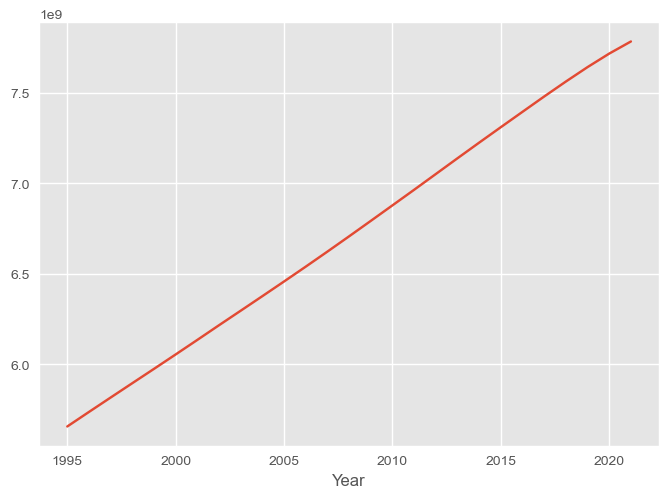

In [37]:
dataset.groupby('Year')['Population'].sum().plot(kind='line')

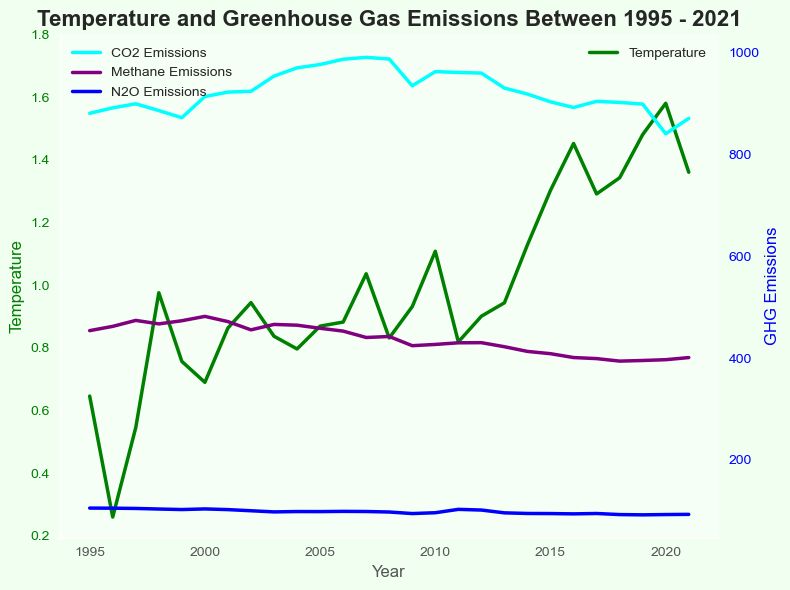

In [38]:

plt.style.use('ggplot')

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

year_temp.plot(kind="line", ax=ax1, color='green', linewidth=2.5)
ax1.set_ylabel("Temperature", color='green')
ax1.tick_params(axis='y', colors='green')

# stacked_data['Total Greenhouse Gas Emissions'].plot(kind="line", ax=ax2, color='blue', linewidth=2.5, label="Total Greenhouse Gas Emissions")
stacked_data['CO2 Emissions'].plot(kind="line", ax=ax2, color='cyan', linewidth=2.5, label="CO2 Emissions")
stacked_data['Methane Emissions'].plot(kind="line", ax=ax2, color='purple', linewidth=2.5, label="Methane Emissions")
stacked_data['Nitrous Oxide Emissions'].plot(kind="line", ax=ax2, color='blue', linewidth=2.5, label="N2O Emissions")
ax2.set_ylabel("GHG Emissions", color='blue')
ax2.tick_params(axis='y', colors='blue')

ax1.set_title("Temperature and Greenhouse Gas Emissions Between 1995 - 2021", fontsize=16, fontweight='bold')
ax1.set_xlabel("Year", fontsize=12)

yticks = np.arange(0.2, 2, 0.2)
ax1.set_yticks(yticks)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(loc='upper left', fontsize=10)

fig.patch.set_facecolor('#f0fff0')
ax1.set_facecolor('#f5fff5')
ax2.set_facecolor('#f5fff5')

ax1.grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()


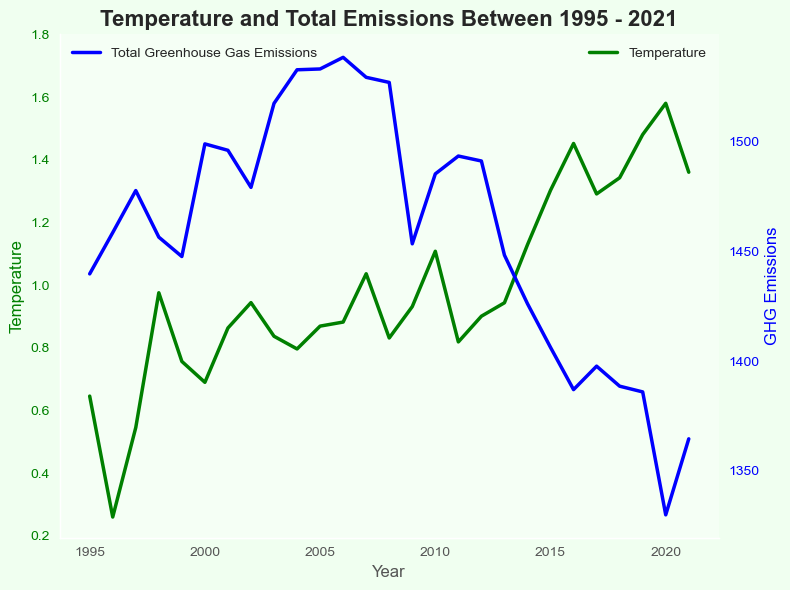

In [39]:

plt.style.use('ggplot')

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

year_temp.plot(kind="line", ax=ax1, color='green', linewidth=2.5)
ax1.set_ylabel("Temperature", color='green')
ax1.tick_params(axis='y', colors='green')

stacked_data['Total Greenhouse Gas Emissions'].plot(kind="line", ax=ax2, color='blue', linewidth=2.5, label="Total Greenhouse Gas Emissions")
ax2.set_ylabel("GHG Emissions", color='blue')
ax2.tick_params(axis='y', colors='blue')

ax1.set_title("Temperature and Total Emissions Between 1995 - 2021", fontsize=16, fontweight='bold')
ax1.set_xlabel("Year", fontsize=12)

yticks = np.arange(0.2, 2, 0.2)
ax1.set_yticks(yticks)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(loc='upper left', fontsize=10)

fig.patch.set_facecolor('#f0fff0')
ax1.set_facecolor('#f5fff5')
ax2.set_facecolor('#f5fff5')

ax1.grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()


# Preprocess 2

In [40]:
co2_df = pd.read_csv("./processed_data/co2_emissions.csv")
temp_df = pd.read_csv("./processed_data/Temperature_of_countries.csv")

t = temp_df.groupby('Year')['Temperature'].mean()

dataset = pd.DataFrame({
    'Temperature': t
})


In [41]:
population_df = pd.read_csv("./processed_data/population.csv")
methane_df = pd.read_csv("./processed_data/methane_emissions.csv")
ni_df = pd.read_csv("./processed_data/nitrous_oxide_emission.csv")

In [42]:
merged_df = pd.merge(co2_df, methane_df, on=['Country', 'ISO', 'Year'], suffixes=('_CO2', '_Methane'), how='inner')
merged_df = pd.merge(merged_df, ni_df, on=['Country', 'ISO', 'Year'], how='inner')
merged_df = pd.merge(merged_df, population_df, on=['Country', 'ISO', 'Year'], how='inner')

In [43]:
annual_co2 = merged_df['Annual CO2 emissions (per capita)'] * merged_df["Population - Sex: all - Age: all - Variant: estimates"]
merged_df.insert(4, "Annual CO2 Emissions", annual_co2)

In [44]:
annual_mh4 = merged_df["Per-capita methane emissions in CO2 equivalents"] * merged_df['Population - Sex: all - Age: all - Variant: estimates']
merged_df.insert(6, "Annual MH4 Emission", annual_mh4)

In [45]:
annual_ni = merged_df['Per-capita nitrous oxide emissions in CO2 equivalents'] * merged_df['Population - Sex: all - Age: all - Variant: estimates']
merged_df.insert(8, "Annual NiO Emissions", annual_ni)

In [46]:
new_features = merged_df.groupby('Year')[['Annual CO2 Emissions', 'Annual MH4 Emission', 'Annual NiO Emissions']].sum()
dataset[['Annual CO2 Emissions', 'Annual MH4 Emissions', 'Annual NiO Emissions']] = new_features[['Annual CO2 Emissions', 'Annual MH4 Emission', 'Annual NiO Emissions']]


In [47]:
dataset.to_csv("dataset/timeseries.csv")

# Model Selection and Development

In [48]:
data = pd.read_csv("dataset/timeseries.csv")

In [49]:
# Drop the last row from the DataFrame
last_row_index = data.index[-1]
data = data.drop(index=last_row_index)

In [50]:
features = ['Annual CO2 Emissions','Annual MH4 Emissions','Annual NiO Emissions']
target = ['Temperature']

X = data[features].values  # Input features
y = data[target].values  # Target variable

In [51]:
# Normalize the input features using MinMaxScaler on the entire dataset
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [52]:
# Define a list of lags to test
LAGS = [1, 2, 3, 4, 5]

In [53]:
# Model storage
MODELS_DICT = {
    'VAR': {
        'models': [],
        'mse': [],
        'rmse': [],
        'lags': []
    },
    'RF': {
        'models': [],
        'mse': [],
        'rmse': [],
        'lags': []
    },
    'LSTM': {
        'models': [],
        'mse': [],
        'rmse': [],
        'lags': []
    },
    'RNN': {
        'models': [],
        'mse': [],
        'rmse': [],
        'lags': []
    },
    'SVR': {
        'models': [],
        'mse': [],
        'rmse': [],
        'lags': []
    },
}

In [54]:
def run_algorithm(model_name):
    '''Run an algorithm based on its name'''
    fig, ax = plt.subplots(len(LAGS), 1, figsize=(10, 20))

    for lag in LAGS:
        X_lagged = np.zeros((len(X_scaled) - lag, lag * X_scaled.shape[1]))
        y_lagged = np.zeros(len(y) - lag)

        for i in range(lag, len(X_scaled)):
            X_lagged[i - lag] = X_scaled[i - lag:i].flatten()
            y_lagged[i - lag] = y[i]

        X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_lagged, test_size=0.2, shuffle=False)

        if model_name == "VAR":
            model = VAR(np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1))
            results = model.fit(maxlags=lag)
            lagged_endog_test = np.concatenate((X_test[-lag:], y_test[-lag:].reshape(-1, 1)), axis=1)

            y_pred_train = results.fittedvalues[:, -1]
            y_pred_test = results.forecast(y=lagged_endog_test, steps=len(y_test))[:, -1]
            
            # Calculate MSE and create plots
            mse_train = mean_squared_error(y_train[lag:], y_pred_train)
            rmse_train = np.sqrt(mse_train)
            
            mse_test = mean_squared_error(y_test, y_pred_test)
            rmse_test = np.sqrt(mse_test)

            MODELS_DICT[model_name]['models'].append(results)
        elif model_name == "RF":
            model = RandomForestRegressor(n_estimators=100)
            model.fit(X_train, y_train)

            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            
            # Calculate MSE and create plots
            mse_train = mean_squared_error(y_train[lag:], y_pred_train[:-lag])
            rmse_train = np.sqrt(mse_train)
            
            mse_test = mean_squared_error(y_test, y_pred_test)
            rmse_test = np.sqrt(mse_test)
            
            MODELS_DICT[model_name]['models'].append(model)
        
        elif model_name == "SVR":
            model = SVR(kernel='rbf')
            model.fit(X_train, y_train)

            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            
            mse_train = mean_squared_error(y_train, y_pred_train)
            rmse_train = np.sqrt(mse_train)
            
            mse_test = mean_squared_error(y_test, y_pred_test)
            rmse_test = np.sqrt(mse_test)

            MODELS_DICT[model_name]['models'].append(model)
        elif model_name == "LSTM" or model_name == "RNN":
            X_train_lstm = X_train.reshape(X_train.shape[0], lag, X_scaled.shape[1])
            X_test_lstm = X_test.reshape(X_test.shape[0], lag, X_scaled.shape[1])

            model = Sequential()
            model.add(LSTM(50, input_shape=(lag, X_scaled.shape[1]), return_sequences=True)) if model_name == "LSTM" else model.add(SimpleRNN(50, input_shape=(lag, X_scaled.shape[1]), return_sequences=True))
            model.add(LSTM(25)) if model_name == "LSTM" else model.add(SimpleRNN(25))
            model.add(Dense(1))
            model.compile(loss='mean_squared_error', optimizer='adam')
            model.fit(X_train_lstm, y_train, epochs=50, batch_size=8, verbose=0)
            y_pred_train = model.predict(X_train_lstm)
            y_pred_test = model.predict(X_test_lstm)
            
            # Calculate MSE and create plots
            mse_train = mean_squared_error(y_train[lag:], y_pred_train[:-lag])
            rmse_train = np.sqrt(mse_train)
            
            mse_test = mean_squared_error(y_test, y_pred_test)
            rmse_test = np.sqrt(mse_test)

            MODELS_DICT[model_name]['models'].append(model)

        MODELS_DICT[model_name]['mse'].append(mse_test)
        MODELS_DICT[model_name]['rmse'].append(rmse_test)
        MODELS_DICT[model_name]['lags'].append(lag)

        train_index = range(len(y_train) - len(y_pred_train), len(y_train))
        test_index = range(len(y_train), len(y_train) + len(y_pred_test))

        if model_name == 'VAR':
            ax[lag - 1].plot(data['Year'][train_index], y_train[lag:], label='Actual Temperature (Train)', linewidth=2, marker="o")
            ax[lag - 1].plot(data['Year'][train_index], y_pred_train, label='Predicted Temperature (Train)', linewidth=2, marker="x")
        else:
            ax[lag - 1].plot(data['Year'][train_index][lag:], y_train[lag:], label='Actual Temperature (Train)', linewidth=2, marker="o")
            ax[lag - 1].plot(data['Year'][train_index][lag:], y_pred_train[:-lag], label='Predicted Temperature (Train)', linewidth=2, marker="x")
        ax[lag - 1].plot(data['Year'][test_index], y_test, label='Actual Temperature (Test)', linewidth=2, marker="o")
        ax[lag - 1].plot(data['Year'][test_index], y_pred_test, label='Predicted Temperature (Test)', linewidth=2, marker="x")
        

        ax[lag - 1].set_xlabel('Sample', fontsize=12)
        ax[lag - 1].set_ylabel('Temperature', fontsize=12)
        ax[lag - 1].set_title(f"{model_name} Lag {lag} ", fontsize=14, fontweight='bold')
        ax[lag - 1].legend(loc='upper left', fontsize=10)
        ax[lag - 1].tick_params(axis='both', which='major', labelsize=10)
        ax[lag - 1].grid(True, linestyle='--', linewidth=0.5)
        
        print(f"{model_name} Lag {lag} - Train MSE: {mse_train:.5f}, Test MSE: {mse_test:.5f}, - Train RMSE: {rmse_train:.5f}, Test RMSE: {rmse_test:.5f} ")


    plt.tight_layout()
    plt.show()



VAR Lag 1 - Train MSE: 0.02847, Test MSE: 0.13358, - Train RMSE: 0.16872, Test RMSE: 0.36549 
VAR Lag 2 - Train MSE: 0.02487, Test MSE: 0.07975, - Train RMSE: 0.15770, Test RMSE: 0.28241 
VAR Lag 3 - Train MSE: 0.01629, Test MSE: 0.28756, - Train RMSE: 0.12762, Test RMSE: 0.53624 
VAR Lag 4 - Train MSE: 0.01118, Test MSE: 0.39850, - Train RMSE: 0.10575, Test RMSE: 0.63127 
VAR Lag 5 - Train MSE: 0.00339, Test MSE: 1.14483, - Train RMSE: 0.05823, Test RMSE: 1.06997 


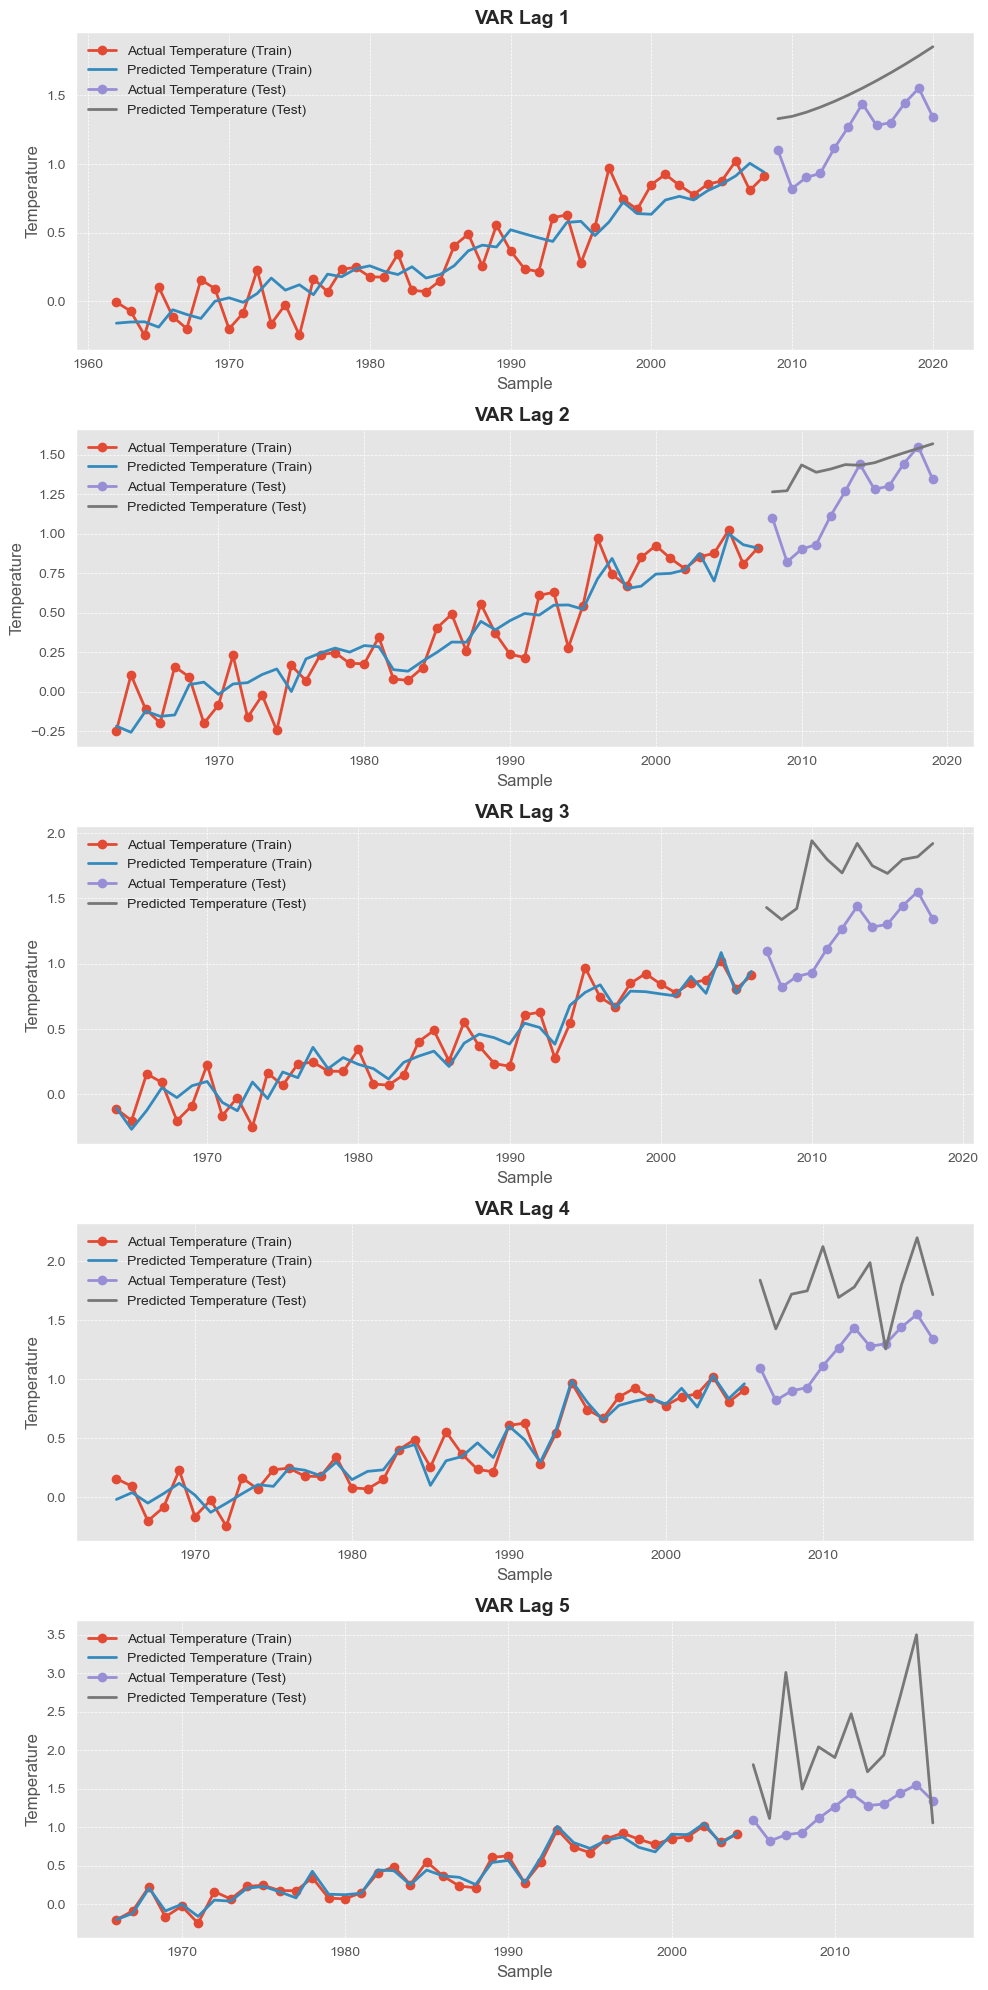

In [55]:
# Call the function with the desired model name
run_algorithm("VAR")


RF Lag 1 - Train MSE: 0.02635, Test MSE: 0.16439, - Train RMSE: 0.16234, Test RMSE: 0.40545 
RF Lag 2 - Train MSE: 0.03808, Test MSE: 0.15560, - Train RMSE: 0.19513, Test RMSE: 0.39446 
RF Lag 3 - Train MSE: 0.03487, Test MSE: 0.16728, - Train RMSE: 0.18673, Test RMSE: 0.40899 
RF Lag 4 - Train MSE: 0.03674, Test MSE: 0.16525, - Train RMSE: 0.19167, Test RMSE: 0.40651 
RF Lag 5 - Train MSE: 0.05545, Test MSE: 0.15789, - Train RMSE: 0.23548, Test RMSE: 0.39736 


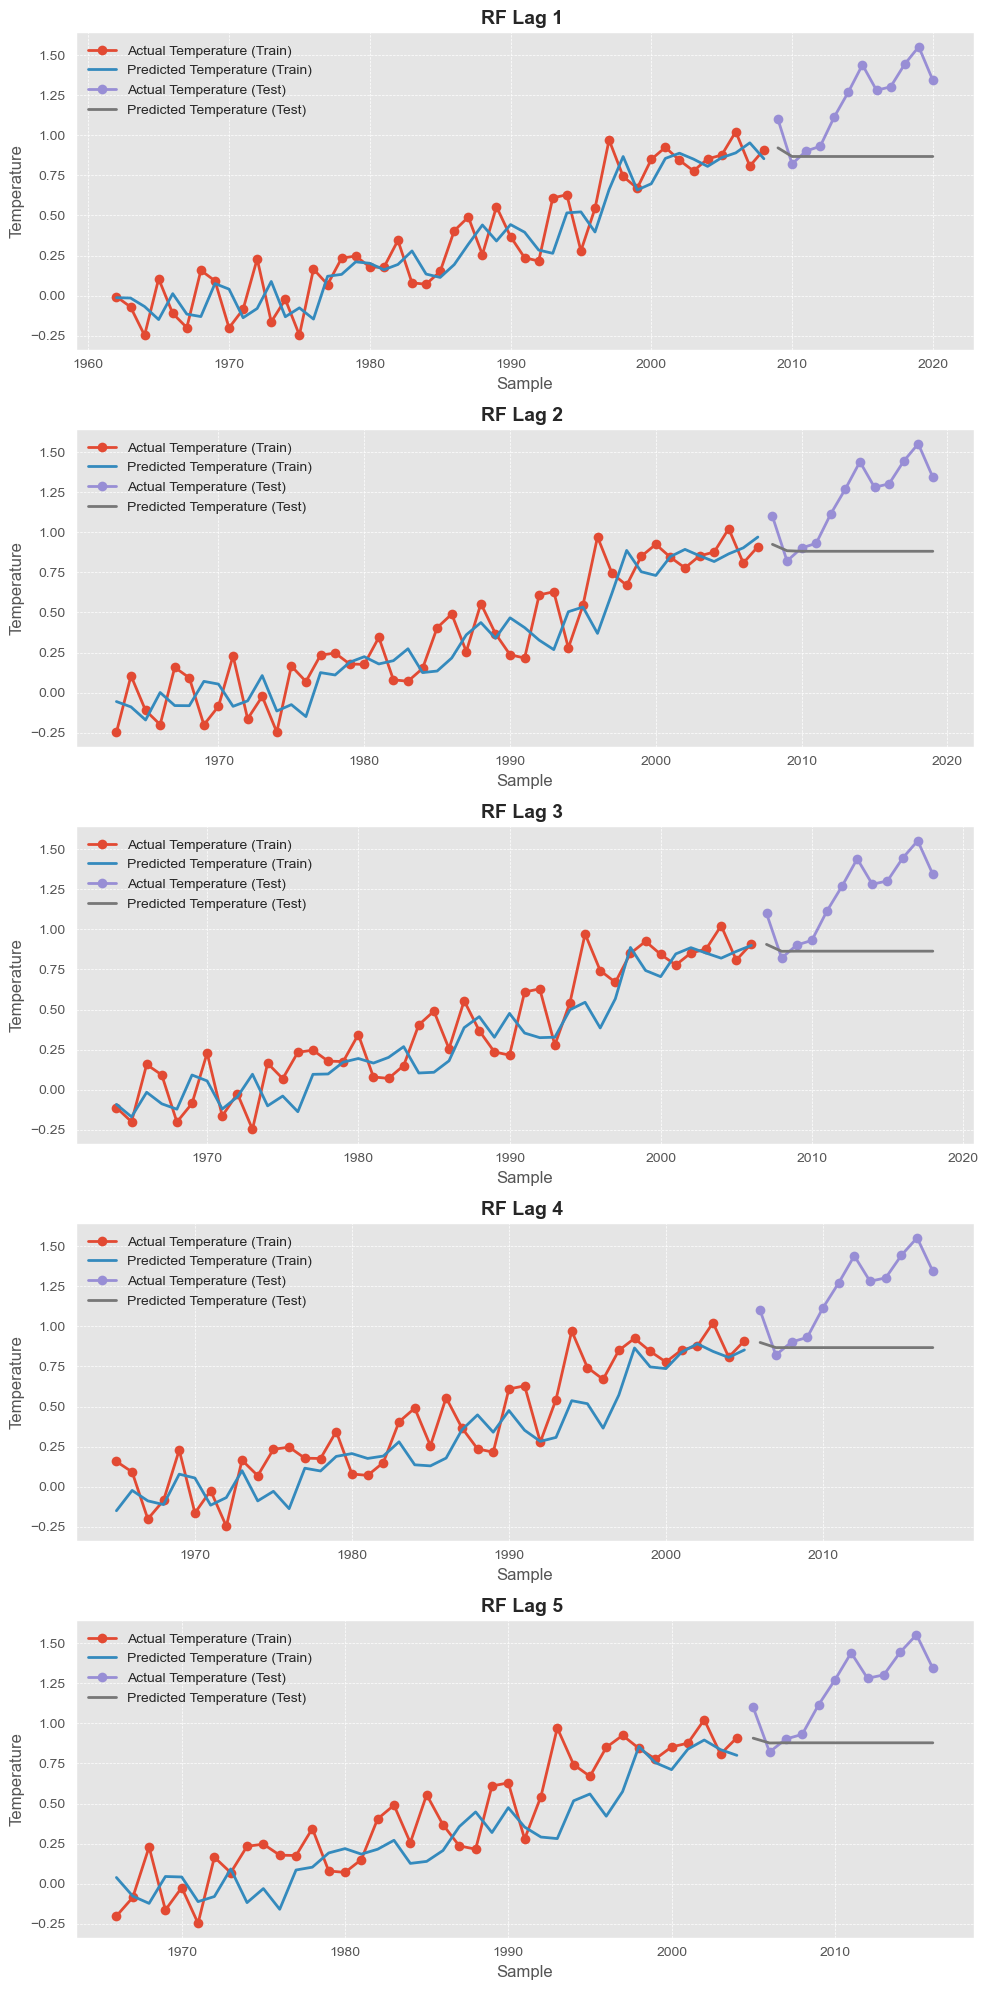

In [57]:
run_algorithm("RF")

SVR Lag 1 - Train MSE: 0.02086, Test MSE: 0.42433, - Train RMSE: 0.14443, Test RMSE: 0.65140 
SVR Lag 2 - Train MSE: 0.02091, Test MSE: 0.49894, - Train RMSE: 0.14462, Test RMSE: 0.70635 
SVR Lag 3 - Train MSE: 0.02093, Test MSE: 0.52349, - Train RMSE: 0.14468, Test RMSE: 0.72353 
SVR Lag 4 - Train MSE: 0.02131, Test MSE: 0.55917, - Train RMSE: 0.14596, Test RMSE: 0.74778 
SVR Lag 5 - Train MSE: 0.02000, Test MSE: 0.57872, - Train RMSE: 0.14141, Test RMSE: 0.76073 


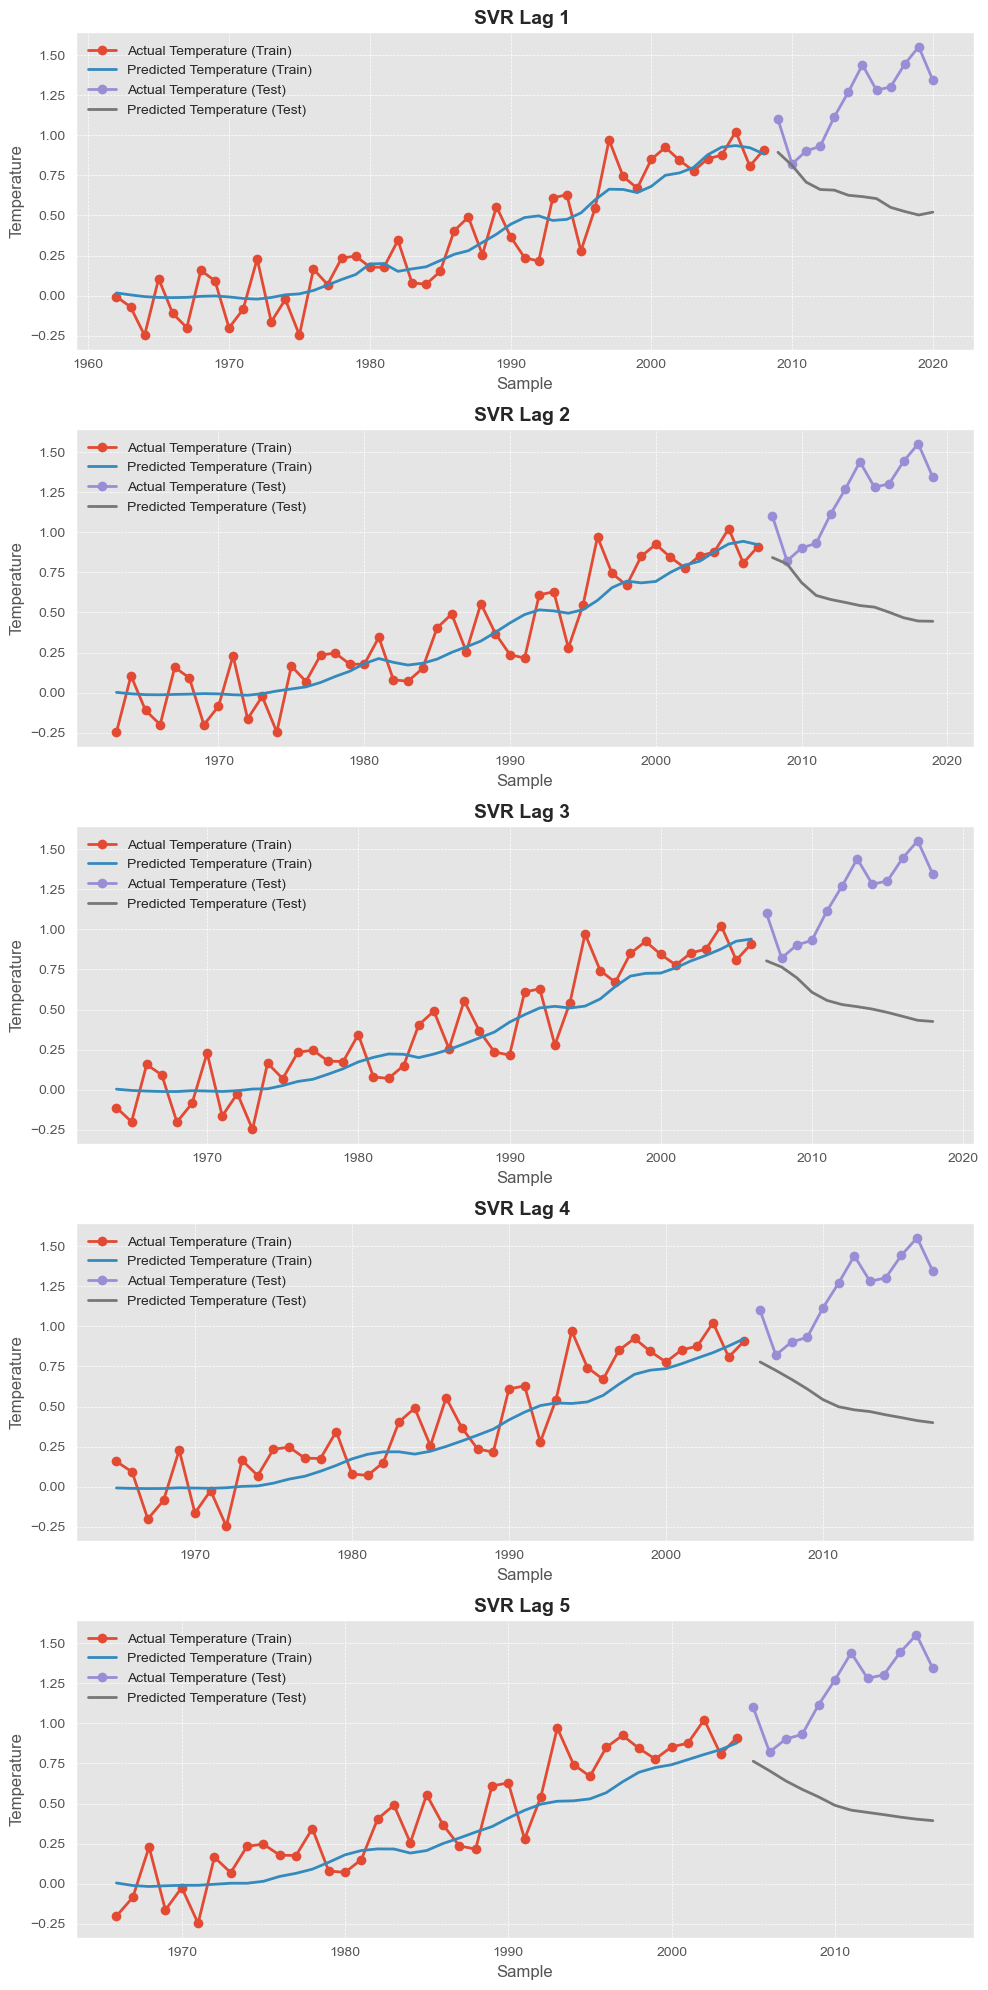

In [58]:
run_algorithm("SVR")

1/1 [==============================] - 0s 50ms/step
LSTM Lag 1 - Train MSE: 0.02908, Test MSE: 0.04879, - Train RMSE: 0.17053, Test RMSE: 0.22088 
1/1 [==============================] - 0s 37ms/step
LSTM Lag 2 - Train MSE: 0.02883, Test MSE: 0.07929, - Train RMSE: 0.16980, Test RMSE: 0.28158 
1/1 [==============================] - 0s 98ms/step
LSTM Lag 3 - Train MSE: 0.03030, Test MSE: 0.08672, - Train RMSE: 0.17406, Test RMSE: 0.29449 
1/1 [==============================] - 0s 32ms/step
LSTM Lag 4 - Train MSE: 0.03202, Test MSE: 0.13249, - Train RMSE: 0.17893, Test RMSE: 0.36399 
1/1 [==============================] - 0s 16ms/step
LSTM Lag 5 - Train MSE: 0.03676, Test MSE: 0.08774, - Train RMSE: 0.19174, Test RMSE: 0.29621 


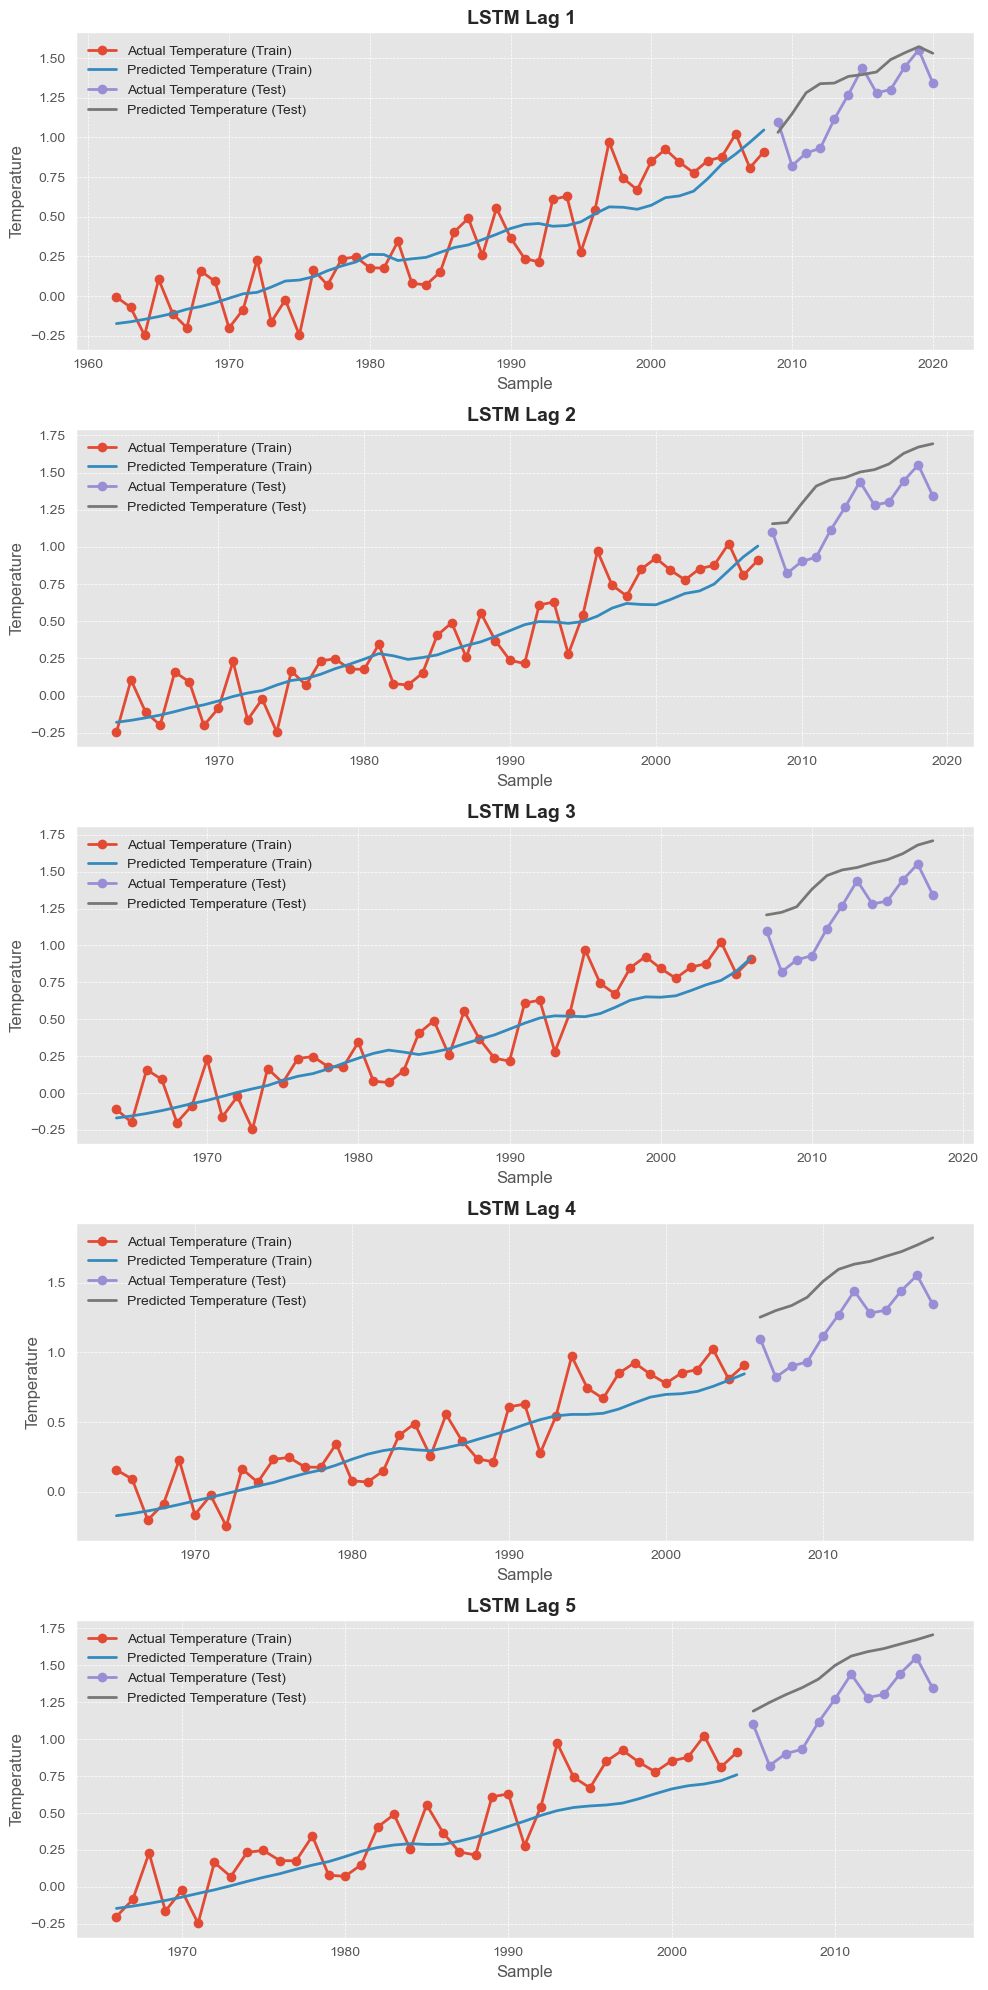

In [59]:
run_algorithm("LSTM")

1/1 [==============================] - 0s 202ms/step
RNN Lag 1 - Train MSE: 0.03538, Test MSE: 0.05835, - Train RMSE: 0.18811, Test RMSE: 0.24155 
1/1 [==============================] - 0s 100ms/step
RNN Lag 2 - Train MSE: 0.03548, Test MSE: 0.03526, - Train RMSE: 0.18836, Test RMSE: 0.18778 
1/1 [==============================] - 0s 48ms/step
RNN Lag 3 - Train MSE: 0.02842, Test MSE: 0.02774, - Train RMSE: 0.16859, Test RMSE: 0.16656 
1/1 [==============================] - 0s 64ms/step
RNN Lag 4 - Train MSE: 0.03410, Test MSE: 0.02930, - Train RMSE: 0.18466, Test RMSE: 0.17116 
1/1 [==============================] - 0s 104ms/step
RNN Lag 5 - Train MSE: 0.05364, Test MSE: 0.03339, - Train RMSE: 0.23160, Test RMSE: 0.18273 


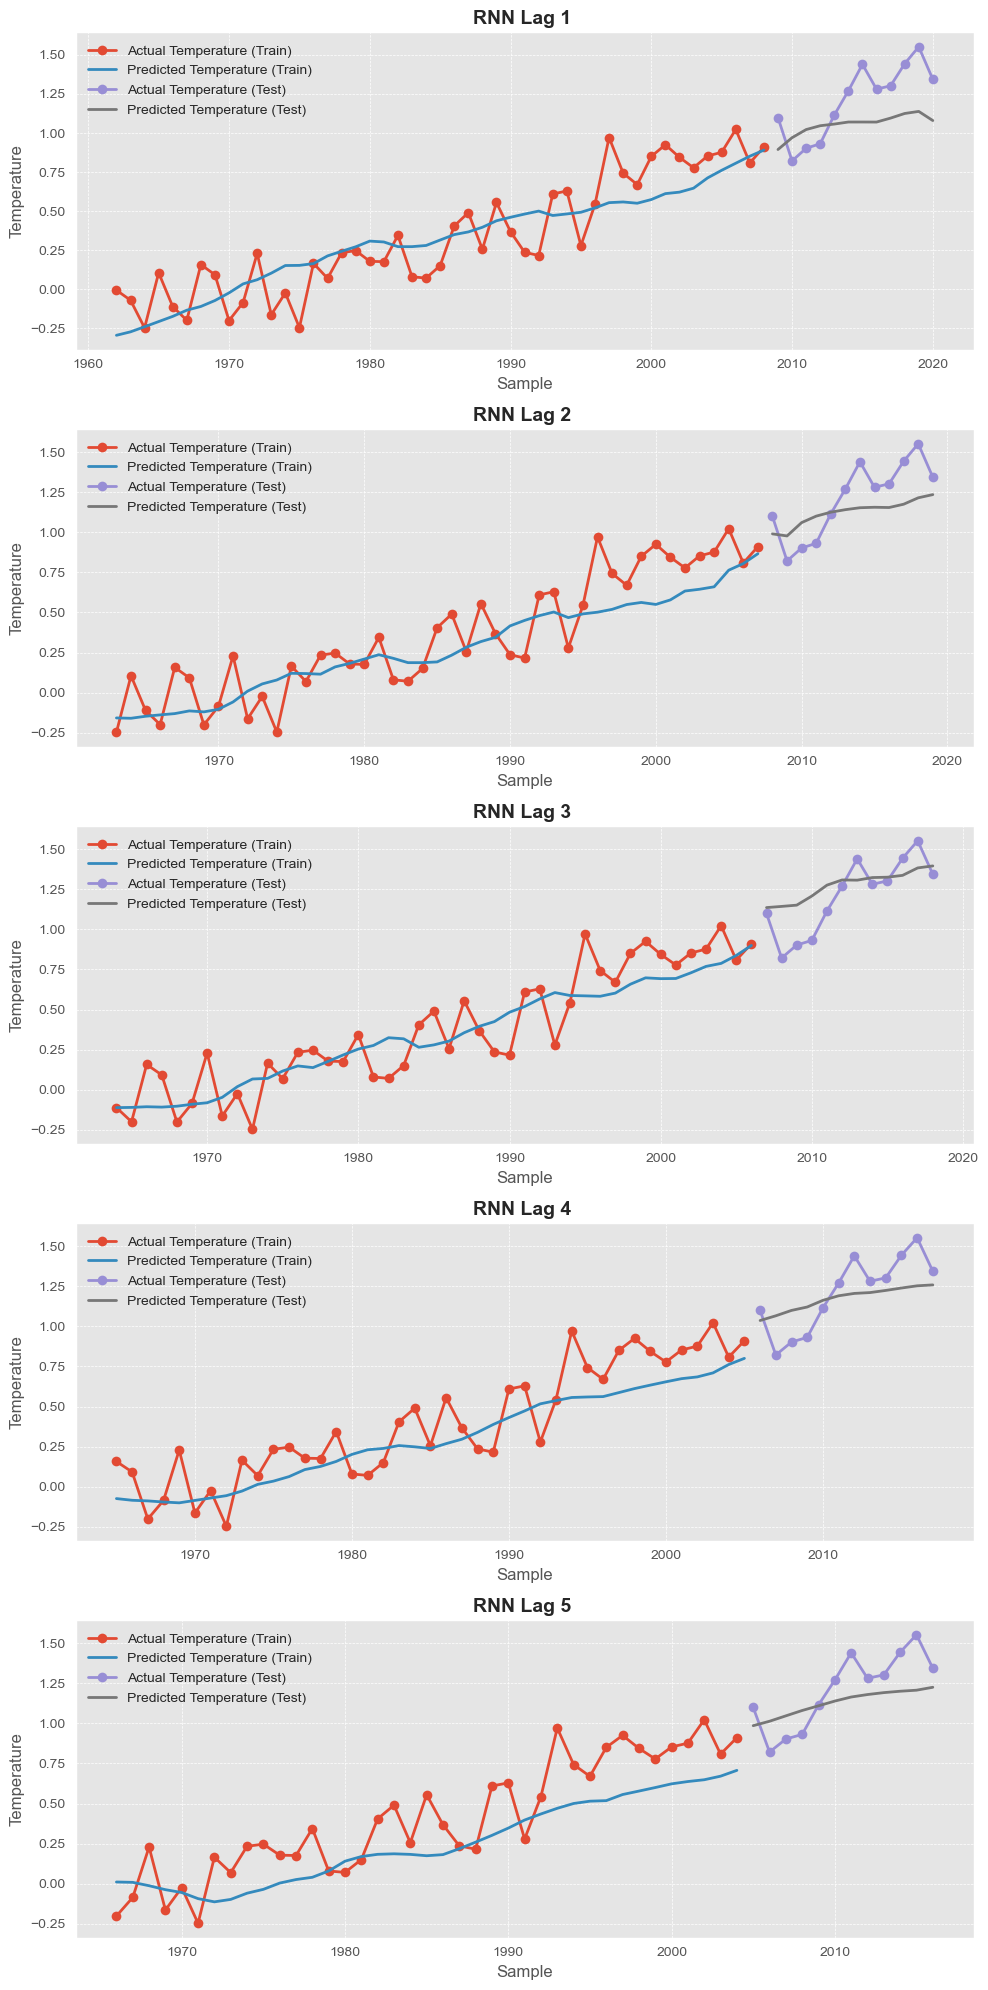

In [60]:
run_algorithm("RNN")

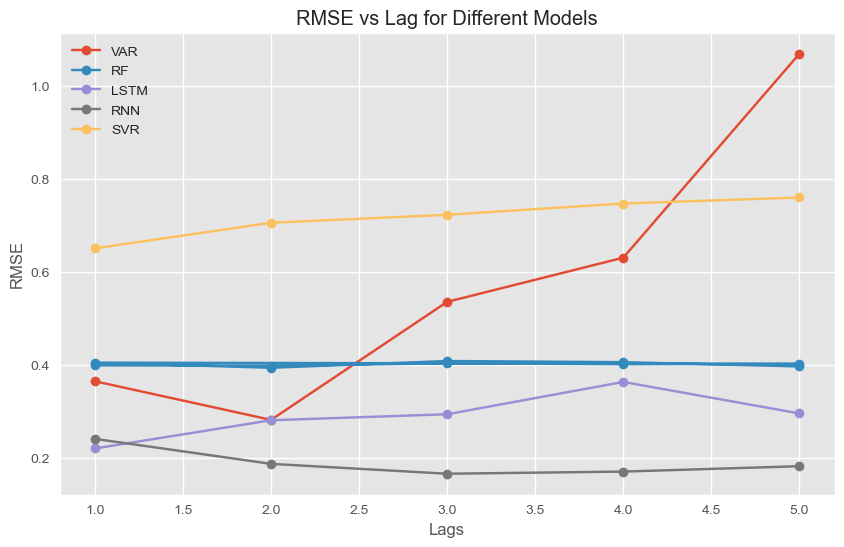

In [61]:
# Plot Error Analyis on all model

df = pd.DataFrame.from_dict(MODELS_DICT, orient='index')
# Create a plot for RMSE vs Lag for each model
fig, ax = plt.subplots(figsize=(10, 6))

for model_name, model_data in df.iterrows():
    ax.plot(model_data['lags'], model_data['rmse'], marker='o', label=model_name)

ax.set_xlabel('Lags')
ax.set_ylabel('RMSE')
ax.set_title('RMSE vs Lag for Different Models')
ax.legend()

plt.show()

In [62]:
def forward_model(model, generated_data_scaled):
    '''Forward models for making predictions'''
    fig, ax = plt.subplots(len(LAGS), 1, figsize=(10, 20))
    predictions = {}

    for idx, lag in enumerate(LAGS):
        X_generated = np.zeros((len(generated_data_scaled) - lag, lag * generated_data_scaled.shape[1]))

        for i in range(lag, len(generated_data_scaled)):
            X_generated[i - lag] = generated_data_scaled[i - lag:i].flatten()

        if model == "VAR":
            results = MODELS_DICT['VAR']['lags'][lag - 1]
            lagged_endog_generated = np.concatenate((X_generated[-lag:], np.zeros((lag, 1))), axis=1)
            y_pred_generated = results.forecast(y=lagged_endog_generated, steps=len(X_generated))[:, -1]
        elif model == "LSTM":
            X_generated_seq = X_generated.reshape(X_generated.shape[0], lag, generated_data_scaled.shape[1])
            model_lstm = MODELS_DICT['LSTM']['lags'][lag - 1]
            y_pred_generated = model_lstm.predict(X_generated_seq)
        elif model == "RNN":
            X_generated_seq = X_generated.reshape(X_generated.shape[0], lag, generated_data_scaled.shape[1])
            model_rnn = MODELS_DICT['RNN']['lags'][lag - 1]
            y_pred_generated = model_rnn.predict(X_generated_seq)

        predictions[str(lag)] = y_pred_generated

        # Plot the years and predictions for different lags
        years_generated = np.arange(2021 + lag, 2051)
        ax[idx].plot(years_generated, predictions[str(lag)], label=f'Predicted Temperature (Lag {lag})', linewidth=2, marker="x")
        ax[idx].set_xlabel('Year', fontsize=12)
        ax[idx].set_ylabel('Temperature', fontsize=12)
        ax[idx].set_title(f"{model} Lag {lag}", fontsize=14, fontweight='bold')
        ax[idx].legend(loc='upper left', fontsize=10)
        ax[idx].tick_params(axis='both', which='major', labelsize=10)
        ax[idx].grid(True, linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

In [63]:
# Define the initial emission values for 2021 for CO2, N2O, and CH4
initial_co2 = data.iloc[-1, :].values[2]  
initial_n2o = data.iloc[-1, :].values[4]
initial_ch4 = data.iloc[-1, :].values[3]

# Define emission increase rates for each gas (for demonstration purposes)
co2_increase_rate = 2.0  
n2o_increase_rate = 1.5  
ch4_increase_rate = 0.5  

In [64]:
# Linear emission Increase

# Generate emission scenarios from 2021 to 2050
years = range(2021, 2051)
co2_emissions_scenario1 = [initial_co2 + co2_increase_rate * (year - 2021) for year in years]
n2o_emissions_scenario1 = [initial_n2o + n2o_increase_rate * (year - 2021) for year in years]
ch4_emissions_scenario1 = [initial_ch4 + ch4_increase_rate * (year - 2021) for year in years]


scenerio1 = pd.DataFrame({
    'Year': years,
    'Annual CO2 Emissions': co2_emissions_scenario1,
    'Annual MH4 Emissions': ch4_emissions_scenario1,
    'Annual NiO Emissions': n2o_emissions_scenario1,
})

scenerio1_X = scenerio1[features].copy()

scenerio1_X_scaled = scaler.fit_transform(scenerio1_X)



KeyError: 0

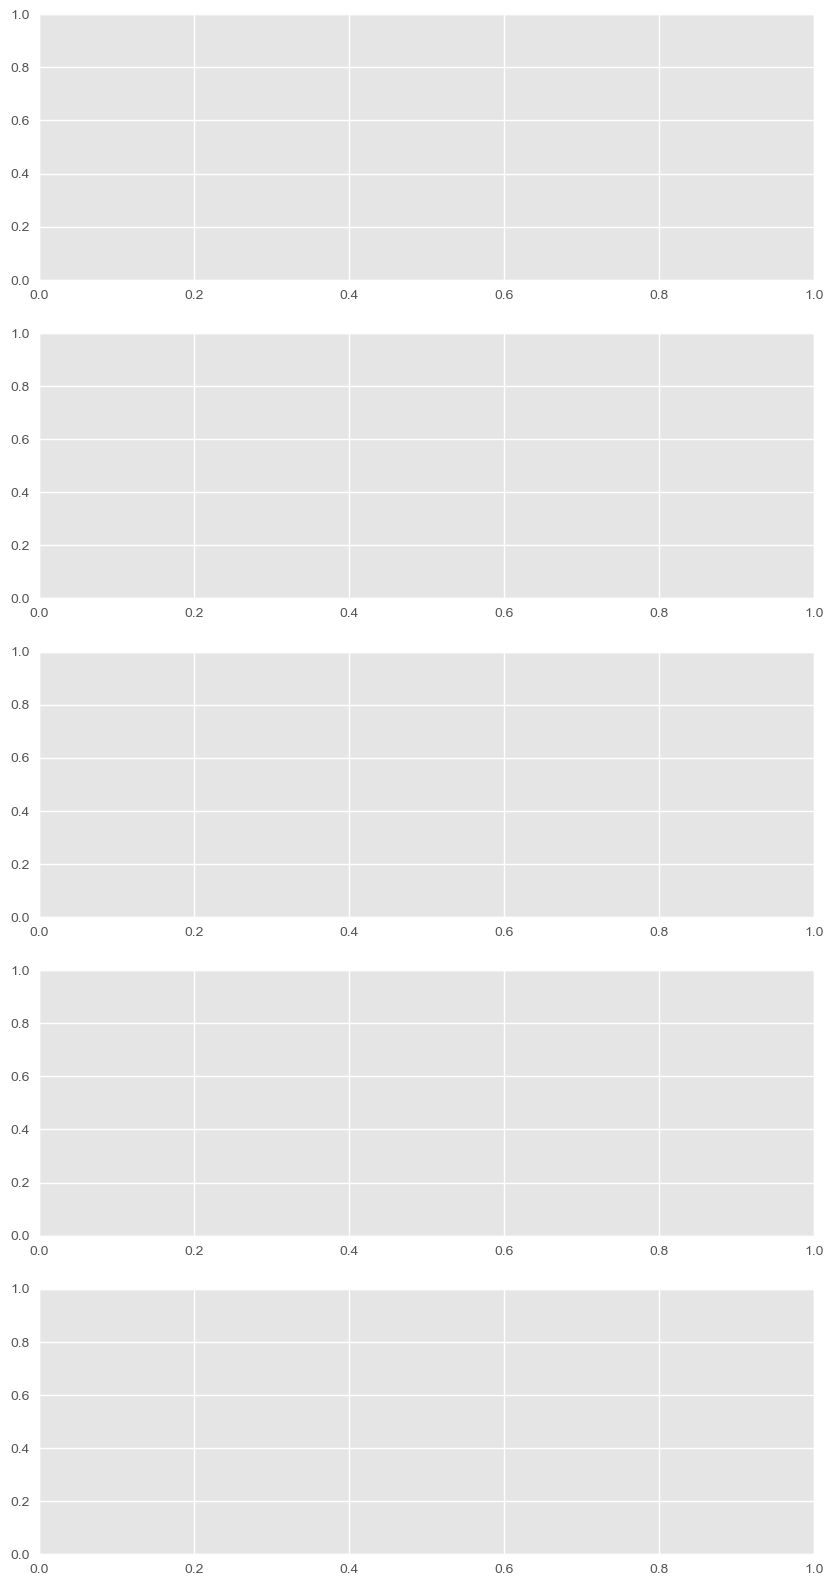

In [65]:
# project VAR on linear emission increase
forward_model("VAR", scenerio1_X_scaled)

In [ ]:
# project RNN on linear emission increase
forward_model("RNN", scenerio1_X_scaled)

In [ ]:
# Linear emission decrease

# Generate emission scenarios from 2021 to 2050
years = range(2021, 2051)
co2_emissions_scenario2 = [initial_co2 - co2_increase_rate * (year - 2021) for year in years]
n2o_emissions_scenario2 = [initial_n2o - n2o_increase_rate * (year - 2021) for year in years]
ch4_emissions_scenario2 = [initial_ch4 - ch4_increase_rate * (year - 2021) for year in years]


scenerio2 = pd.DataFrame({
    'Year': years,
    'Annual CO2 Emissions': co2_emissions_scenario2,
    'Annual MH4 Emissions': ch4_emissions_scenario2,
    'Annual NiO Emissions': n2o_emissions_scenario2,
})

scenerio2_X = scenerio2[features].copy()

scenerio2_X_scaled = scaler.fit_transform(scenerio2_X)

In [ ]:
# project VAR on linear emission decrease
forward_model("VAR", scenerio2_X_scaled)

In [ ]:
# project RNN on linear emission decrease
forward_model("RNN", scenerio2_X_scaled)

In [ ]:
# Constant emission

# Generate emission scenarios from 2021 to 2050
years = range(2021, 2051)
co2_emissions_scenario3 = [initial_co2 for year in years]
n2o_emissions_scenario3 = [initial_n2o for year in years]
ch4_emissions_scenario3 = [initial_ch4 for year in years]


scenerio3 = pd.DataFrame({
    'Year': years,
    'Annual CO2 Emissions': co2_emissions_scenario3,
    'Annual MH4 Emissions': ch4_emissions_scenario3,
    'Annual NiO Emissions': n2o_emissions_scenario3,
})

scenerio3_X = scenerio3[features].copy()

scenerio3_X_scaled = scaler.fit_transform(scenerio3_X)

In [ ]:
# project VAR on constant emission
forward_model("VAR", scenerio3_X_scaled)

In [ ]:
# project VAR on constant emission
forward_model("RNN", scenerio3_X_scaled)